In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import co2_timeseries_tools as co2tt
from scipy import stats
from ctsm_py import utils

# Observational Data

Add additional observed data as text files, then add to ESRL list

In [2]:
path='/glade/work/dll/CTSM_py/notebooks/'
brw={'name':'Barrow', 'acronym': 'brw',  'lat': 71.3, 'lon':360-156.61, 'z': 11.0}
mlo={'name':'Mauna Loa', 'acronym': 'mlo', 'lat': 19.5, 'lon':360-155.6, 'z':3397.0}
alt={'name':'Alert', 'acronym': 'alt', 'lat': 82.5, 'lon':360-62.5, 'z':200.0}
azr={'name': 'Azores', 'acronym':'azr','lat':38.8, 'lon':360-27.4, 'z':19.0}
cba={'name': 'Cold Bay', 'acronym':'cba', 'lat':55.2, 'lon':360-162.7, 'z':21.3}
kum={'name':'Kumukahi', 'acronym':'kum', 'lat':19.7, 'lon':360-155.0, 'z':0.3}
ESRL=[brw, mlo, alt, azr, cba, kum]
lats=np.array([71.3,19.5,82.5,38.8,55.2,19.7])
lons=np.array([360-156.61,360-155.6,360-62.5,360-27.4,360-162.7,360-155.0])
#note that the 'lev' variable only goes from 0 to 1000, not sure how to translate from 'alt' to 'lev'
alt=np.array([11.0,3397.0,200.0,19.0,21.3,0.3])

Looping over all sites to read in file

In [8]:
minYear = 1981 # minimum year for an 'early' trend, used later for plotting

for site in ESRL:
#    print(site)
    filename=path+'co2_'+site['acronym']+'_surface-flask_1_ccgg_month.txt'
    #import glob
    #filename=glob.glob(partialname+ '*co2')
    with open(filename, 'r') as fid:
        first_line=fid.readline()
        nheader=first_line[-3:-1]
        nheader=np.int(np.float(nheader))
    data=np.loadtxt(filename, usecols=(1,2,3), skiprows=nheader)
    time=data[:,0]+data[:,1]/12
    co2=data[:,2]
    month=data[:,1]
    year=data[:,0]
    site['year']=year
    site['month']=month
    site['co2']=co2
    
    # detrended annual cycle using Gretchen's functions
    # done w/in this loop for ease
    # how many years of data needed in function? 
    print(site['acronym']+' first year '+str(min(year)) )
    if min(year) < minYear:
        j=np.where(year<(minYear+1))
        early_co2detrend=co2tt.poly3detrend(year[j], month[j], co2[j])
        early_co2mm=co2tt.compute_mm(month[j], early_co2detrend)
        site['early_co2detrend'] = early_co2detrend
        site['early_co2mm'] = early_co2mm
    
    # Repeat for the end of the record
    j=np.where(year>2010)
    late_co2detrend=co2tt.poly3detrend(year[j], month[j], co2[j])
    late_co2mm=co2tt.compute_mm(month[j], late_co2detrend)
    site['late_co2detrend'] = late_co2detrend
    site['late_co2mm'] = late_co2mm

brw first year 1971.0
mlo first year 1969.0
alt first year 1985.0
azr first year 1979.0
cba first year 1978.0
kum first year 1976.0


### Plot full time series at each site

[71.3, 19.5, 82.5, 38.8, 55.2, 19.7]


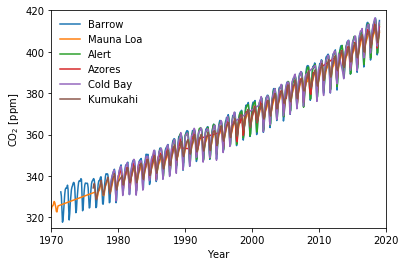

In [15]:
# made a list to store site names more easily
labels = [''] * len(ESRL)
obsLat = [np.nan] * len(ESRL)
obsLon = [np.nan] * len(ESRL)
obsEle = [np.nan] * len(ESRL)

#loop through each of the sites [i] in ESRL
for i in range(len(ESRL)):
    plt.plot(ESRL[i]['year']+ESRL[i]['month']/12.0, ESRL[i]['co2'])
    plt.ylabel(r'CO$_2$ [ppm]')
    plt.xlabel('Year')
    plt.ylim(315,420)
    plt.xlim(1970,2020)
    labels[i] = ESRL[i]['name'] 
    obsLat[i] = ESRL[i]['lat'] 
    obsLon[i] = ESRL[i]['lon'] 
    obsEle[i] = ESRL[i]['z'] 
plt.legend(labels=labels, frameon=False);

print(obsLat)
#plt.savefig('BRWTimeseries.eps')

Plotting 
Only plotting last site in ESRL. Iterate (?) to loop over and plot all sites

### Plot seasonal cycle at each site
- This could be done nicer with sharex=True and sharey=True
- https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html

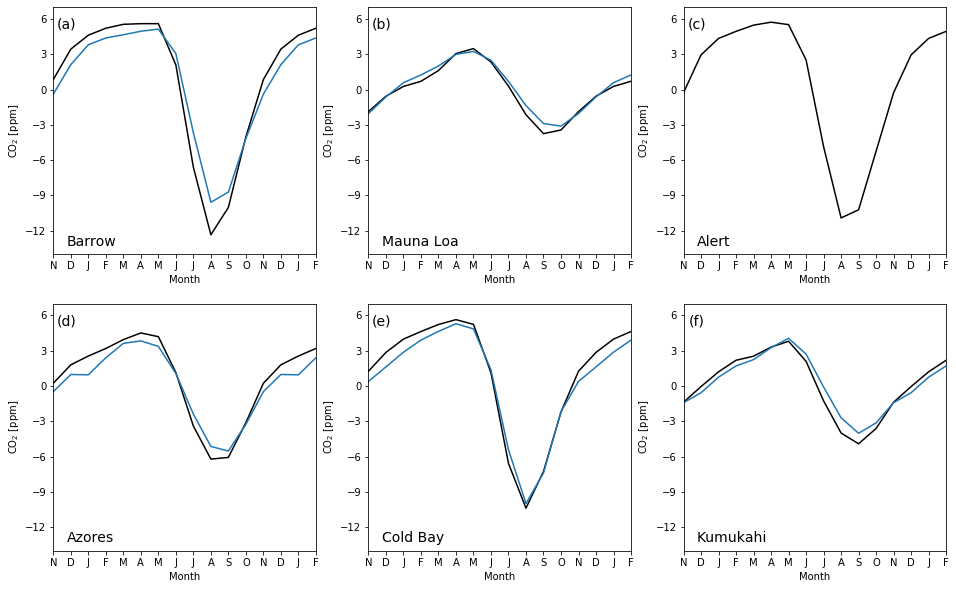

In [10]:
# Late PLOTS -- define late part of record
panel = ['(a)','(b)','(c)','(d)','(e)','(f)'] #to label panels

plt.figure(figsize=[16,10])
for i in range(len(ESRL)):
    late_co2mm  = ESRL[i]['late_co2mm']
    if min(ESRL[i]['year']) < minYear:
        early_co2mm = ESRL[i]['early_co2mm']
  
    plot_early=np.hstack([np.transpose(early_co2mm[10:12]), np.transpose(early_co2mm), np.transpose(early_co2mm[0:2])])
    plot_late=np.hstack([np.transpose(late_co2mm[10:12]), np.transpose(late_co2mm), np.transpose(late_co2mm[0:2])])
    
    # Make subplot
    plt.subplot(2,3,(i+1))  
    plt.figure(1, figsize=(3.5,3))
    #plt.plot(np.arange(0,16), plot_early, 'b')
    plt.plot(np.arange(0,16), plot_late, 'k') ### Note that I pre-pend and append extra months to the figure
    xticklab=(['N', 'D', 'J', 'F', 'M','A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F'])
    ax=plt.gca()
    ax.set_xticks(np.arange(0,16))
    ax.set_xticklabels(xticklab)
    plt.ylabel(r'CO$_2$ [ppm]')
    plt.xlabel('Month')
    plt.xlim([0,15])
    plt.ylim([-14,7])
    ax.set_yticks(np.arange(-12,9,3))
    # add panel label to top left
    plt.text(0.05, 0.93,panel[i], fontsize=14,
         ha='center', va='center', transform=plt.gca().transAxes)
    # add panel label to bottom left
    plt.text(0.05, 0.05,labels[i], fontsize=14,
         ha='left', va='center', transform=plt.gca().transAxes)
    
    # overlay 
    if min(ESRL[i]['year']) < minYear:
        plt.plot(plot_early)
    #plt.plot(plot_late)
    #plt.savefig('BRW_early_late.eps')

# Model Data
Code converted from ~/AmplitudeAnalysis/CESM_CO2AmpTrend_Regions_Altitude_withNoFert.ncl

Defining directories and simulation names

In [31]:
simyrs             = "185001-201412"
var                = "CO2"

datadir            = "/glade/p/cesm/lmwg_dev/dll/"
subdir             = "/atm/proc/tseries/month_1/"
Mod1dir            = "CESM2_Coupled_NoCrop/"
Mod2dir            = "CESM2_Coupled_NoFert/"

sim                = "b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001"
sim2               = "b40.20th.1deg.coup.001"
sim3               = "b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.002_NoCropSpin_Transient1970-2014"
sim4               = "b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.002_NoFert_Transient1970-2014"

Reading in simulations

In [32]:
data1          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+sim+".cam.h0."+var+"."+simyrs+".nc", decode_times=True), 'time')
data2          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+sim2+".cam2.h0."+var+".185001-200512.nc", decode_times=True), 'time')
data3          = utils.time_set_mid(xr.open_dataset(datadir+Mod1dir+subdir+sim3+".cam.h0."+var+".197001-201412.nc", decode_times=True), 'time')
data4          = utils.time_set_mid(xr.open_dataset(datadir+Mod2dir+subdir+sim4+".cam.h0."+var+".197001-201412.nc", decode_times=True), 'time')

Concatenating data variables into a dictionary

In [33]:
sims = dict()
sims['CESM2']           = data1.CO2
sims['CESM1']           = data2.CO2
sims['nocrop']          = data3.CO2
sims['nofert']          = data4.CO2

simtitles = ['CESM2','CESM1','CESM2 Generic Crop','CESM2 No Fertilization']

Reading in area data

In [34]:
#collectionsdir = "/glade/collections/cdg/data/CMIP6/CMIP/NCAR/"
#model          = "CESM2"
#simtype        = "historical"
#varsn          = "gn"
#latest         = "latest"
#ensmem         = "r1i1p1f1"

#areadir    = (collectionsdir+model+"/"+simtype+"/"+ensmem+"/fx/")
#areavar    = "areacella"
#fracvar    = "sftlf"

In [35]:
#areadata   = xr.open_dataset(areadir+areavar+"/"+varsn+"/"+latest+"/areacella_fx_CESM2_historical_r1i1p1f1_gn.nc")
#fracdata   = xr.open_dataset(areadir+fracvar+"/"+varsn+"/"+latest+"/sftlf_fx_CESM2_historical_r1i1p1f1_gn.nc")

In [36]:
#area = areadata.areacella
#frac = fracdata.sftlf

### Conversions

In [ ]:
#import metpy as metpy
#from metpy.units import units

In [11]:
convert = 1.0**6 * 28.966/44.0

#landarea       = area*1.0**6*frac
#landarea.attrs['units']   = 'm^2'

In [ ]:
#print(sims)

In [ ]:
#%%time
#cesm2_kg = data1.CO2

In [ ]:
#print(type(convert))
#print(type(cesm2_kg))

In [ ]:
#%%time
#cesm2_ppm = cesm2_kg*convert
#cesm2_ppm = cesm2_kg.sel(lev=slice(31))*convert

In [ ]:
%%time
#keys_list = list(sims)
#cesm2 = keys_list[0]

#cesm2 = data1.CO2 * convert
#cesm1 = data2.CO2 * convert
#nocrop = data3.CO2 * convert
#nofert = data4.CO2 * convert


#sims_ppm = sims.values() * convert

#for sims, n in sims.items():
#    sims_ppm = n * convert

In [ ]:
#testing out slices
#sims.keys()
#cesm2_kg  = sims['CESM2']
#cesm2slice  = cesm2_kg.sel(time=slice('1970','2014'))

In [ ]:
# to select a grid cell use something like this
# ds.sel(lat=obsLat, lon=obsLon, method='nearest')

In [12]:
%%time
#This was taking a long time (computer hang?) -- need to confirm whether it works
# Should I pull out information for each site and convert only that? 
#Perhaps I can index using lat, lon, and z from the ERSL list?
#Currently, substting time works more quickly (~5 minutes)
for name, data in sims.items():
    ppm = data.sel(time=slice('1970','2014')) * convert
    ppm.attrs['units'] = 'ppm'
    sims[name] = ppm

CPU times: user 53.1 s, sys: 1min 50s, total: 2min 43s
Wall time: 7min 9s


In [13]:
print(sims['CESM2'])

<xarray.DataArray 'CO2' (time: 540, lev: 32, lat: 192, lon: 288)>
array([[[[0.000335, ..., 0.000335],
         ...,
         [0.000335, ..., 0.000335]],

        ...,

        [[0.000338, ..., 0.000338],
         ...,
         [0.000346, ..., 0.000346]]],


       ...,


       [[[0.000407, ..., 0.000407],
         ...,
         [0.000406, ..., 0.000406]],

        ...,

        [[0.000413, ..., 0.000413],
         ...,
         [0.000423, ..., 0.000423]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) object 1970-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    units:    ppm


In [ ]:
#print(sims)
#lats=np.array([71.3,19.5,82.5,38.8,55.2,19.7])
#lons=np.array([360-156.61,360-155.6,360-62.5,360-27.4,360-162.7,360-155.0])
#heights=np.array([11.0,3397.0,200.0,19.0,21.3,0.3])
CESM2 = sims['CESM2']
print(type(CESM2))
#print(ESRL[1][2])
#can't figure out how to pull the lats out of the ESRL list. 
#should be the 3rd element in the list, although here it doesn't seem to like the subsetting option. 
#perhaps just write out a list of all lats and a list of lons. 
#print(ESRL)
#print(ESRL[1][2])
#print(CESM2.sel(lat=ESRL[mlo]['lat']))
#look up 'zip'
#mlCESM2 = CESM2.sel(lat=ESRL[mlo:'lat'])

#print(CESM2[lats])

#point = CESM2.sel(lat=slice(lats[0]))
#numsims = len(ESRL)

#What do I iterate over in the for loop???
points = {}
for x in range(6):
#    print(x)
    pointloop = CESM2.sel(lat=lats[x], lon=lons[x], lev=[-1], method="nearest")
    points[x] = pointloop
#    print(pointloop)
print(points)


In [ ]:
x = 0
print(ESRL['names'])
#print(x)
pointloop = CESM2.sel(lat=lats[x], lon=lons[x], lev=[-1], method="nearest")
points[x] = pointloop
print(points)

In [ ]:
print(sims)

In [14]:
for name, data in sims.items():
    for x in range(6):
        pointloop = data.sel(lat=lats[x], lon=lons[x], lev=[-1], method="nearest")
        points[x] = pointloop
        #how to save points for outter loop
    sims[name]=points

NameError: name 'points' is not defined

In [ ]:
print(sims)